<a href="https://colab.research.google.com/github/Srija-Swarna/Assignment-3---Individual-project/blob/main/Assignment_3_Individual_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code starts by importing a set of necessary libraries and modules. numpy is used for numerical operations, datasets from the Hugging Face library is utilized to load and handle datasets, and transformers provides tools for using BERT (Bidirectional Encoder Representations from Transformers), a powerful transformer-based model. Specifically, BertTokenizer and BertForSequenceClassification are used for tokenizing text and for defining the BERT model with a sequence classification task. Trainer and TrainingArguments are utilities for training the model, while DataCollatorWithPadding helps in dynamically padding the input data. The pipeline function is used for easy application of the model to new inputs. For evaluation, accuracy_score from sklearn.metrics is used to calculate accuracy

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requir

In [2]:
# Importing Necessary Libraries
import numpy as np
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

The dataset "dvilasuero/ag_news_error_analysis" is loaded using the load_dataset function. This dataset contains text inputs and their associated annotations, which the model will use for training and evaluation. The structure and content of the dataset are printed to the console, allowing for an initial inspection of the data.

In [3]:
# Loading and Printing the Dataset
dataset = load_dataset("dvilasuero/ag_news_error_analysis")
print("Dataset:", dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/499 [00:00<?, ? examples/s]

Dataset: DatasetDict({
    train: Dataset({
        features: ['inputs', 'annotation', 'annotation_agent'],
        num_rows: 499
    })
})


The BERT tokenizer and model are loaded from the pre-trained 'bert-base-uncased' model. The tokenizer is responsible for converting raw text into token IDs that the model can process. The model is initialized for a sequence classification task with four labels, indicating it will classify inputs into one of four possible categories.

In [4]:
# Loading the Tokenizer and the Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


A function preprocess_function is defined to tokenize the inputs from the dataset. This function uses the BERT tokenizer to encode the text data, ensuring each input is padded and truncated to a maximum length of 256 tokens. The function also sets the 'labels' field, which corresponds to the annotations in the dataset, making sure the labels are available during training. The dataset is then tokenized and converted into a format suitable for PyTorch tensors, with the necessary columns (input_ids, attention_mask, labels) retained.

In [5]:
# Tokenizing the Dataset
def preprocess_function(examples):
    tokenized = tokenizer(examples['inputs'], padding="max_length", truncation=True, max_length=256)
    tokenized['labels'] = examples['annotation']  # Ensure 'labels' are included
    return tokenized

tokenized_datasets = dataset.map(preprocess_function, batched=True)
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/499 [00:00<?, ? examples/s]

The training portion of the tokenized dataset is further split into a smaller training set and a validation set using the train_test_split method. This step is crucial for evaluating the model's performance on unseen data (validation set) during training, helping to monitor for overfitting and to tune hyperparameters.

In [6]:
# Splitting the Training dataset into Train and Validation sets
small_train_dataset = tokenized_datasets['train'].train_test_split(test_size=0.1)
train_dataset = small_train_dataset['train']
eval_dataset = small_train_dataset['test']

A DataCollatorWithPadding is instantiated, which pads the inputs dynamically to the same length within a batch. This is essential for efficient processing in batches during training. The TrainingArguments object is configured with various parameters: the directory for saving model outputs (output_dir), evaluation strategy (epoch to evaluate after each epoch), learning rate, batch sizes for training and evaluation, number of training epochs, weight decay for regularization, and logging settings.

In [7]:
# Preparing the Data Collator and Training Arguments
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


The compute_metrics function calculates the accuracy of the model's predictions. It takes the output of the model predictions and computes the predicted class labels by taking the argmax of the logits. It then compares these predictions to the true labels (p.label_ids) to calculate the accuracy score using accuracy_score from scikit-learn.

In [8]:
# Defining the compute_metrics Function
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, predictions)}

The Trainer class is instantiated with the model, training arguments, training dataset, evaluation dataset, data collator, and the metrics computation function. The Trainer class simplifies the training loop by managing the training process, including model updates, evaluation, and logging.

In [9]:
# Initializing the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  # Provide the evaluation dataset
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

The training process is initiated using the trainer.train() method. During training, the model learns to minimize the loss by adjusting its weights based on the backpropagation of errors. The model's performance is periodically evaluated on the validation set, and the best model (if applicable) is saved to the specified output directory.

In [10]:
# Training the Model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.298800,1.211970,0.480000
2,1.143100,1.122639,0.500000
3,1.092200,1.120924,0.500000


TrainOutput(global_step=171, training_loss=1.176876841929921, metrics={'train_runtime': 72.3247, 'train_samples_per_second': 18.624, 'train_steps_per_second': 2.364, 'total_flos': 177208477894656.0, 'train_loss': 1.176876841929921, 'epoch': 3.0})

After training, the model's performance is evaluated on the validation set using the trainer.evaluate() method. This provides metrics, including validation accuracy, which is printed to the console.

In [11]:
# Evaluating the Model
eval_results = trainer.evaluate()
print(f"Validation Accuracy: {eval_results.get('eval_accuracy', 'N/A'):.4f}")

Validation Accuracy: 0.5000


Predictions are made on the evaluation dataset, and the resulting predicted labels (y_pred) are compared with the true labels (y_true). A confusion matrix is computed and visualized using Seaborn to show the number of correct and incorrect predictions for each class. This visualization helps to understand the model's performance in detail. Additionally, a classification report is generated using classification_report from scikit-learn, providing precision, recall, F1-score, and support for each class. This report is printed to give a comprehensive view of the model's classification performance.

In [12]:
# Predicting from the Evaluation Dataset
predictions = trainer.predict(eval_dataset)

In [13]:
# Predicted Labels and True Labels
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

In [14]:
# Computing the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

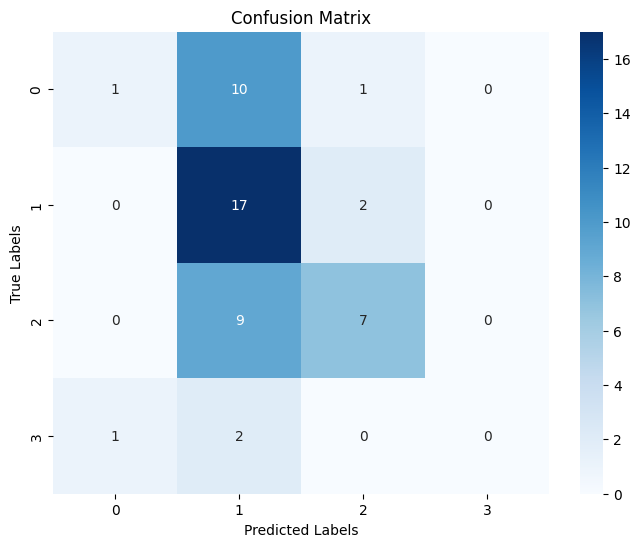

In [15]:
# Displaying the Confusion Matrix Using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Generating a Classification Report
report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
print(report)

              precision    recall  f1-score   support

     Class 0       0.50      0.08      0.14        12
     Class 1       0.45      0.89      0.60        19
     Class 2       0.70      0.44      0.54        16
     Class 3       0.00      0.00      0.00         3

    accuracy                           0.50        50
   macro avg       0.41      0.35      0.32        50
weighted avg       0.51      0.50      0.43        50



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Classifying the specific sentences and comparing with true labels
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
